# Jun ??st, 2022 (Debug degree)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(128)

mode = 'ca2'
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

In [3]:
adj_all = []
for key in mice.ca:
    net = Network(mice=mice, key=key, mode=mode).load_network()
    adj_all.append(np.expand_dims(net.adj, 0))
adj_all = np.concatenate(adj_all)
adj_all.shape

(110, 152, 152)

In [4]:
key = mice.get_key(9, 2, 1)
net = Network(mice=mice, key=key, mode=mode, prep_data=True).load_network()

i = list(mice.ca).index(key)
i

90

<matplotlib.colorbar.Colorbar object at 0x7fa6dff83070>

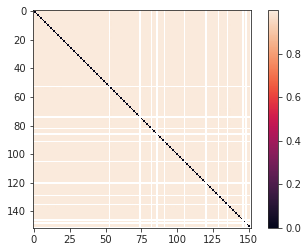

In [5]:
plt.imshow(adj_all[i])
plt.colorbar()

<AxesSubplot:ylabel='Count'>

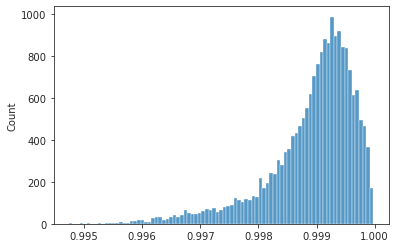

In [6]:
sns.histplot(adj_all[i][adj_all[i] > 0])

<AxesSubplot:ylabel='Count'>

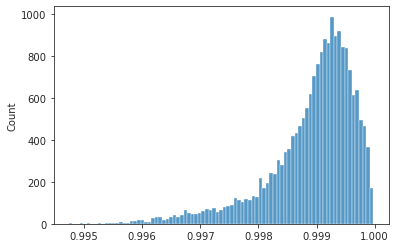

In [7]:
sns.histplot(net.adj[net.adj > 0])

In [9]:
net.data.shape

(152, 4190)

[<matplotlib.lines.Line2D object at 0x7fa6a40979a0>]

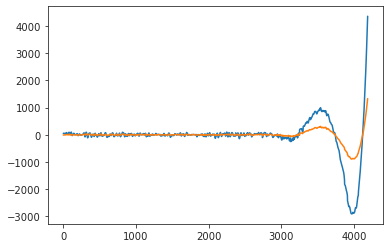

In [13]:
plt.plot(net.data[13])
plt.plot(net.data[79])

In [15]:
x = mice.ca[key][:]

In [16]:
x.shape

(152, 4190)

[<matplotlib.lines.Line2D object at 0x7fa6a4051e80>]

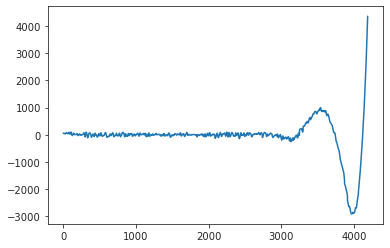

In [17]:
plt.plot(x[13])

In [18]:
mice.setup_preproc_data()

In [24]:
y = mice.ca_preproc[key].load_ants().numpy().squeeze()
y.shape

(256, 250, 5999)

[<matplotlib.lines.Line2D object at 0x7fa6a309a5b0>]

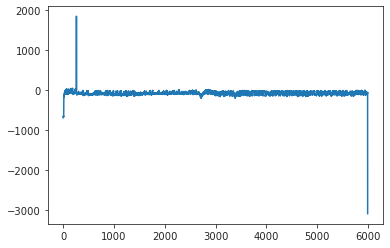

In [29]:
plt.plot(y.mean(0).mean(0))

In [28]:
key

'sub-SLC09_ses-2_run-1'

In [30]:
mice.cfg.exclude

50

In [3]:
task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt_ca = BootStrap(**props_ca)
bt_bo = BootStrap(**props_bo)

### None SciPy vs SciPy

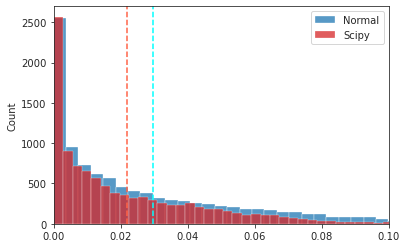

In [4]:
se, f = bt_ca.fit_boot(True, False)
sns.histplot(se[np.isfinite(se)], label='Normal')
plt.axvline(bn.nanmean(se), color='cyan', ls='--')

se, f = bt_ca.fit_boot(True, True)
sns.histplot(se[np.isfinite(se)], label='Scipy', color='C3')
plt.axvline(bn.nanmean(se), color='tomato', ls='--')
plt.xlim(0., 0.10)
plt.legend()
plt.show()

## How mu = 0.003, alpha = 0.05 looks: raw vs. prune

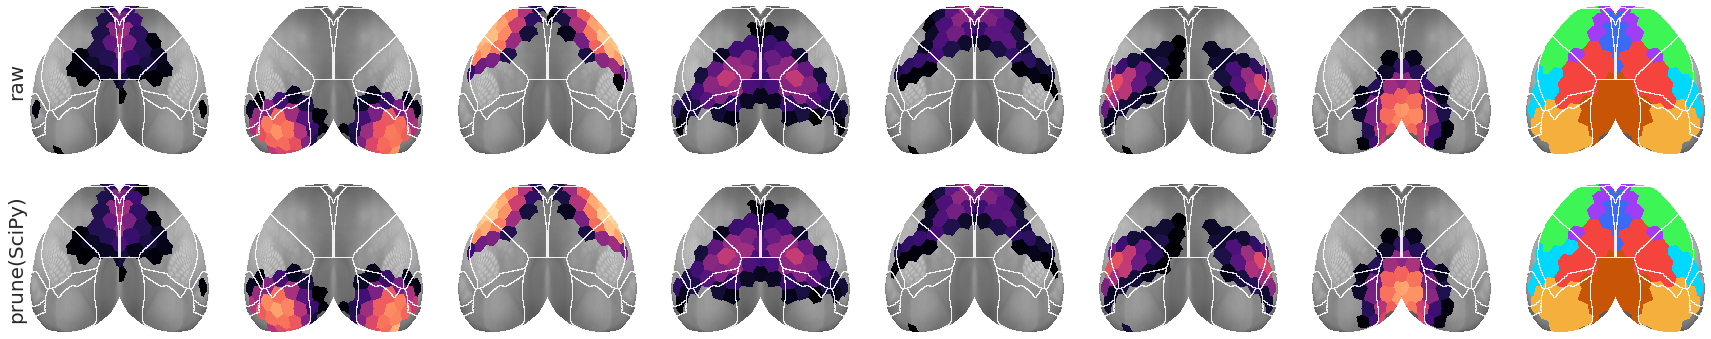

In [5]:
_ = bt_ca.show(
    data={'raw': avg(bt_ca.run_pi), 'prune(SciPy)': avg(bt_ca.pi_prune)},
    figsize=(30, 6),
    ylabel_fontsize=20,
)

In [6]:
bt_ca.pi_symmetry_score(avg(bt_ca.pi_prune))

(
    {
        1: 0.99,
        2: 0.986,
        3: 0.995,
        4: 0.994,
        5: 0.985,
        6: 0.988,
        7: 0.997,
        -1: 0.991
    },
    {
        1: 0.987,
        2: 1.0,
        3: 0.974,
        4: 0.974,
        5: 0.987,
        6: 0.974,
        7: 1.0,
        -1: 0.985
    }
)

In [7]:
bt_ca.pi_symmetry_score(avg(bt_ca.run_pi))

(
    {
        1: 0.989,
        2: 0.99,
        3: 0.995,
        4: 0.994,
        5: 0.988,
        6: 0.991,
        7: 0.998,
        -1: 0.992
    },
    {
        1: 0.987,
        2: 1.0,
        3: 0.974,
        4: 0.987,
        5: 0.987,
        6: 0.987,
        7: 1.0,
        -1: 0.989
    }
)

## Effect of mu and alpha on distribution of rejected values

### Ca2 (128)

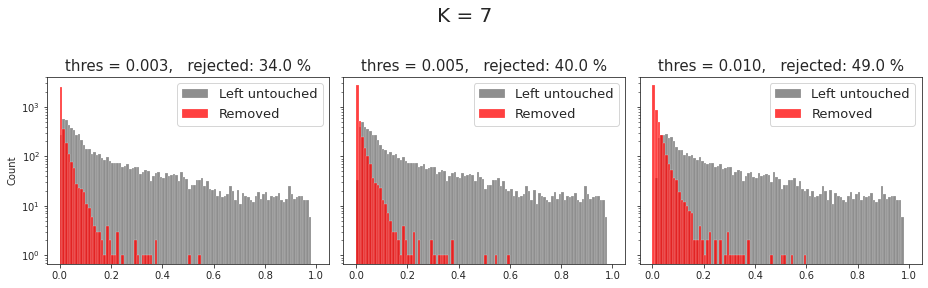

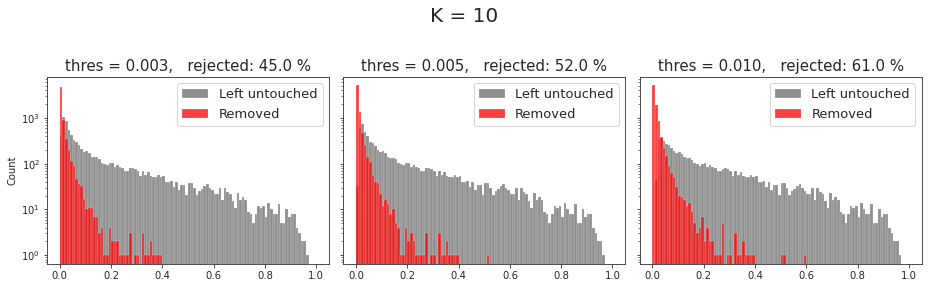

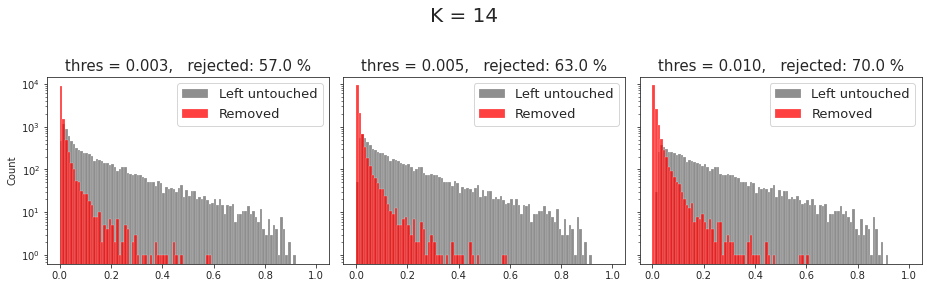

In [105]:
for kk in [7, 10, 14]:
    props_ca['num_k'] = kk
    bt_ca = BootStrap(**props_ca)
    se_indiv, f = bt_ca.fit_boot(True, True)
    
    fig, axes = create_figure(1, 3, (13, 3.8), 'all', 'all')

    for ax, mu in zip(axes.flat, [0.003, 0.005, 0.01]):
        reject, pvals = bt_ca.ttest(se_indiv, mu=mu)
        percen = (reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum()) * 100
        ax.set_title(f'thres = {mu:0.3f},   rejected: {np.round(percen)} %', fontsize=15)

        removed = avg(bt_ca.run_pi, 2, 1)[reject == 0]
        remained = avg(bt_ca.run_pi, 2, 1)[reject == 1]
        sns.histplot(remained, bins=np.linspace(0, 1, 101), label='Left untouched', color='dimgrey', ax=ax)
        sns.histplot(removed, bins=np.linspace(0, 1, 101), label='Removed', color='r', ax=ax)
        ax.legend(fontsize=13)
        ax.set_yscale('log')
    fig.suptitle(f"K = {kk}", y=1.04, fontsize=20)
    plt.show()

### Bold (128)

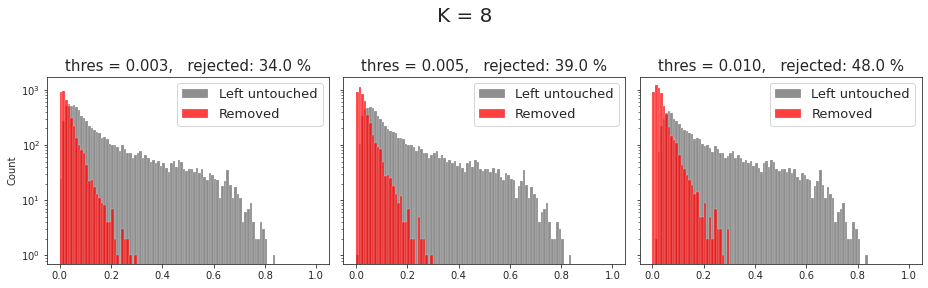

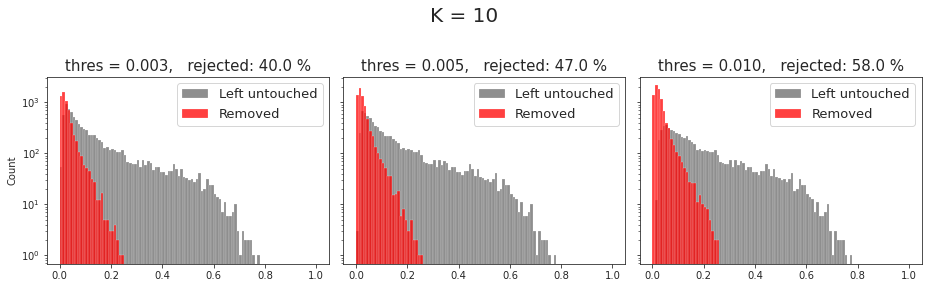

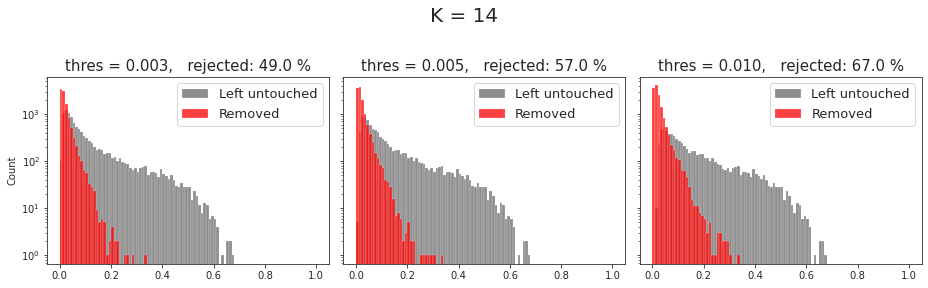

In [108]:
for kk in [8, 10, 14]:
    props_bo['num_k'] = kk
    bt_bo = BootStrap(**props_bo)
    se_indiv, f = bt_bo.fit_boot(True, True)
    
    fig, axes = create_figure(1, 3, (13, 3.8), 'all', 'all')

    for ax, mu in zip(axes.flat, [0.003, 0.005, 0.01]):
        reject, pvals = bt_bo.ttest(se_indiv, mu=mu, alpha=0.01)
        percen = (reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum()) * 100
        ax.set_title(f'thres = {mu:0.3f},   rejected: {np.round(percen)} %', fontsize=15)

        removed = avg(bt_bo.run_pi, 2, 1)[reject == 0]
        remained = avg(bt_bo.run_pi, 2, 1)[reject == 1]
        sns.histplot(remained, bins=np.linspace(0, 1, 101), label='Left untouched', color='dimgrey', ax=ax)
        sns.histplot(removed, bins=np.linspace(0, 1, 101), label='Removed', color='r', ax=ax)
        ax.legend(fontsize=13)
        ax.set_yscale('log')
    fig.suptitle(f"K = {kk}", y=1.04, fontsize=20)
    plt.show()

## Now look at the same thing but nn=512

In [2]:
mice = Mice(512)

task = 'rest'
b = (0.01, 0.5)
mice.setup_func_data(task, band_ca=b)

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt_ca = BootStrap(**props_ca)
bt_bo = BootStrap(**props_bo)

### Ca2 (512)

Selected:
- $\alpha$ = 0.05
- $\mu$ = 0.003

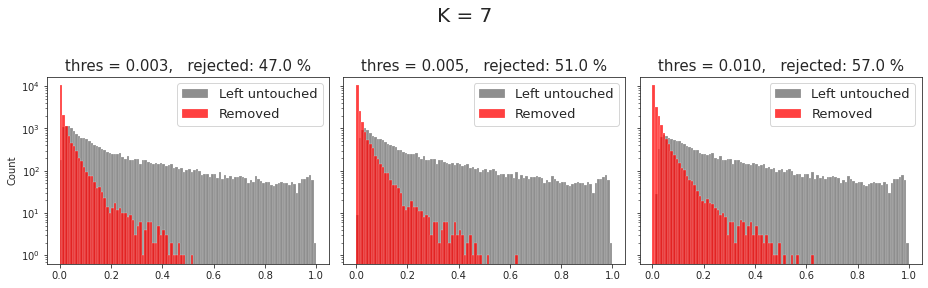

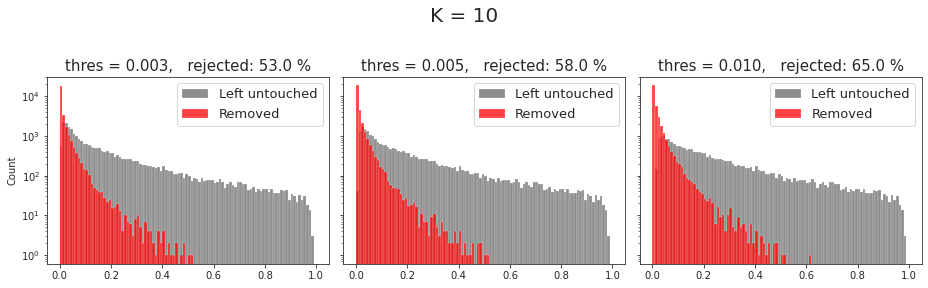

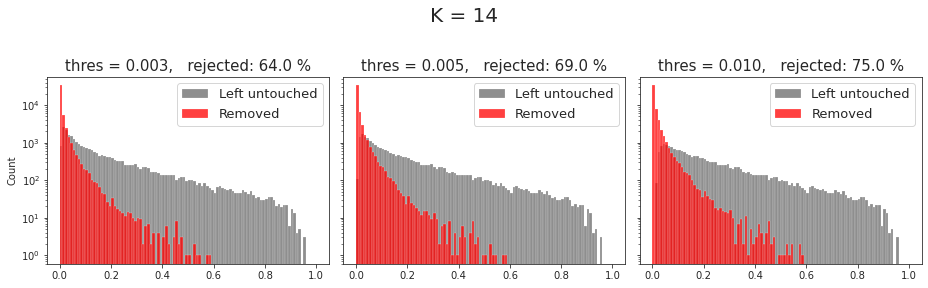

In [3]:
for kk in [7, 10, 14]:
    props_ca['num_k'] = kk
    bt_ca = BootStrap(**props_ca)
    se_indiv, f = bt_ca.fit_boot(True, True)
    
    fig, axes = create_figure(1, 3, (13, 3.8), 'all', 'all')

    for ax, mu in zip(axes.flat, [0.003, 0.005, 0.01]):
        reject, pvals = bt_ca.ttest(se_indiv, mu=mu)
        percen = (reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum()) * 100
        ax.set_title(f'thres = {mu:0.3f},   rejected: {np.round(percen)} %', fontsize=15)

        removed = avg(bt_ca.run_pi, 2, 1)[reject == 0]
        remained = avg(bt_ca.run_pi, 2, 1)[reject == 1]
        sns.histplot(remained, bins=np.linspace(0, 1, 101), label='Left untouched', color='dimgrey', ax=ax)
        sns.histplot(removed, bins=np.linspace(0, 1, 101), label='Removed', color='r', ax=ax)
        ax.legend(fontsize=13)
        ax.set_yscale('log')
    fig.suptitle(f"K = {kk}", y=1.04, fontsize=20)
    plt.show()

### Bold (512)

Selected:
- $\alpha$ = 0.01
- $\mu$ = 0.005

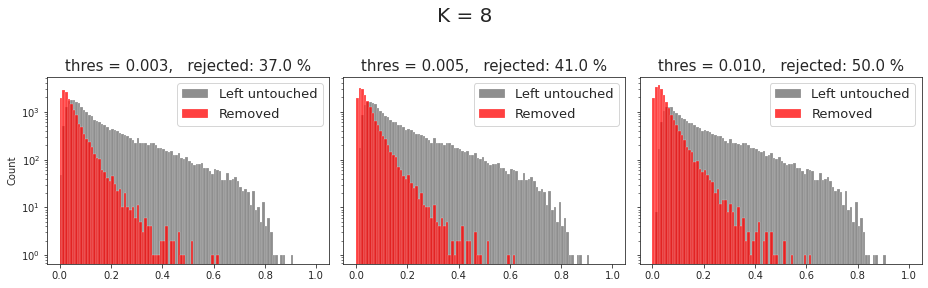

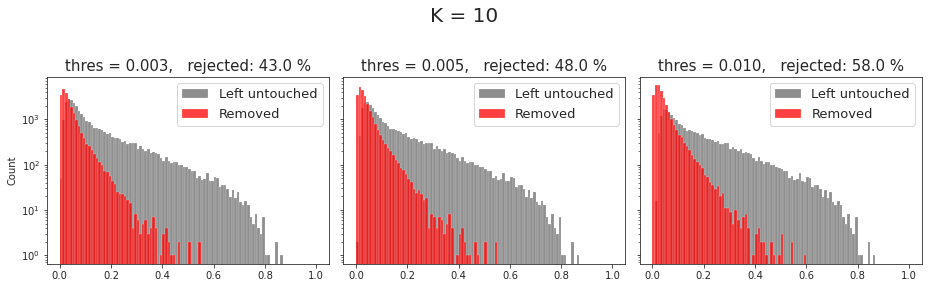

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [7]:
for kk in [8, 10, 14]:
    props_bo['num_k'] = kk
    bt_bo = BootStrap(**props_bo)
    se_indiv, f = bt_bo.fit_boot(True, True)
    
    fig, axes = create_figure(1, 3, (13, 3.8), 'all', 'all')

    for ax, mu in zip(axes.flat, [0.003, 0.005, 0.01]):
        reject, pvals = bt_bo.ttest(se_indiv, mu=mu, alpha=0.01)
        percen = (reject == 0).sum() / ((reject == 0).sum() + (reject == 1).sum()) * 100
        ax.set_title(f'thres = {mu:0.3f},   rejected: {np.round(percen)} %', fontsize=15)

        removed = avg(bt_bo.run_pi, 2, 1)[reject == 0]
        remained = avg(bt_bo.run_pi, 2, 1)[reject == 1]
        sns.histplot(remained, bins=np.linspace(0, 1, 101), label='Left untouched', color='dimgrey', ax=ax)
        sns.histplot(removed, bins=np.linspace(0, 1, 101), label='Removed', color='r', ax=ax)
        ax.legend(fontsize=13)
        ax.set_yscale('log')
    fig.suptitle(f"K = {kk}", y=1.04, fontsize=20)
    plt.show()

## This was about how rejecteds are distributed over seed level

In [26]:
reject = np.expand_dims(np.expand_dims(np.expand_dims(
    reject, 1), 1), 1)
for i in range(1, 4):
    reject = np.repeat(reject, bt_ca.run_pi.shape[i], axis=i)
reject.shape

(10, 3, 4, 300, 7, 152)

In [29]:
aaa = bt_ca.run_pi[reject == 0]
aaa = aaa[np.isfinite(aaa)]

bbb = collections.Counter(np.round(aaa, 3))
ccc = bbb.most_common()

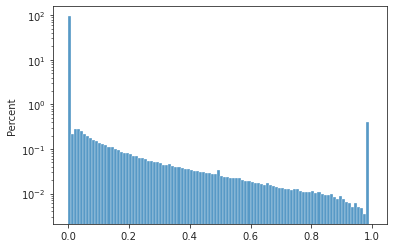

In [30]:
sns.histplot(aaa, stat='percent', bins=np.linspace(0, 1, 101))
plt.yscale('log')

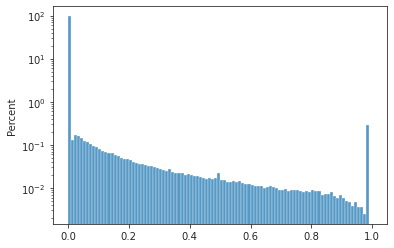

In [31]:
ccc[:20]

[
    (0.002, 13554159),
    (0.988, 36510),
    (0.003, 20663),
    (0.987, 16751),
    (0.004, 9990),
    (0.005, 7238),
    (0.006, 5890),
    (0.007, 5026),
    (0.008, 4572),
    (0.023, 4279),
    (0.024, 4229),
    (0.026, 4228),
    (0.027, 4179),
    (0.025, 4163),
    (0.028, 4133),
    (0.009, 4128),
    (0.031, 4113),
    (0.022, 4071),
    (0.034, 4058),
    (0.032, 4052)
]

In [32]:
aaa = bt_ca.run_pi[reject == 1]
aaa = aaa[np.isfinite(aaa)]

bbb = collections.Counter(np.round(aaa, 3))
ccc = bbb.most_common()

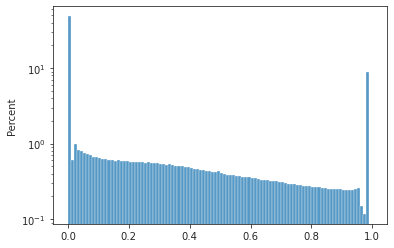

In [33]:
sns.histplot(aaa, stat='percent', bins=np.linspace(0, 1, 101))
plt.yscale('log')

In [34]:
ccc[:20]

[
    (0.002, 7659760),
    (0.988, 940350),
    (0.987, 447529),
    (0.003, 50567),
    (0.986, 34029),
    (0.004, 25747),
    (0.005, 19061),
    (0.024, 17150),
    (0.025, 16851),
    (0.023, 16753),
    (0.026, 16122),
    (0.027, 15837),
    (0.022, 15836),
    (0.006, 15545),
    (0.028, 15535),
    (0.021, 15408),
    (0.029, 15039),
    (0.031, 14587),
    (0.03, 14431),
    (0.032, 13765)
]

In [52]:
x = np.logical_and(bt_ca.run_pi < 0.003, reject == 1)
ids = list(zip(*np.where(x)))
len(ids)

7691788

In [54]:
ids[4035254]

(4, 2, 0, 226, 0, 120)

In [55]:
bt_ca.run_pi[4, 2, 0, 226][:, 120]

memmap([0.00208657, 0.00208657, 0.0020873 , 0.49734745, 0.00208642,
        0.00208569, 0.49222   ])

In [56]:
reject[4, 2, 0, 226][:, 120]

array([1., 1., 0., 1., 1., 1., 1.])

In [60]:
avg(bt_ca.run_pi, 2, 1)[4, :, 120]

array([0.23148495, 0.23600097, 0.00982987, 0.14873405, 0.13178551,
       0.14071516, 0.10144949])

In [8]:
bt_ca.get_booter()

<function BootStrap.get_booter.<locals>.do_boot at 0x7f2bc9b64f70>

In [45]:
pi = avg(self.pi_prune)
members = np.zeros(pi.shape)
alpha = 0.05

for mu in [0.2, 0.1, 0.05, 0]:
    reject, pvals = self.ttest(se, pi, mu=mu, alpha=alpha)
    members[reject == 1] += 1
members /= np.nanmax(members)

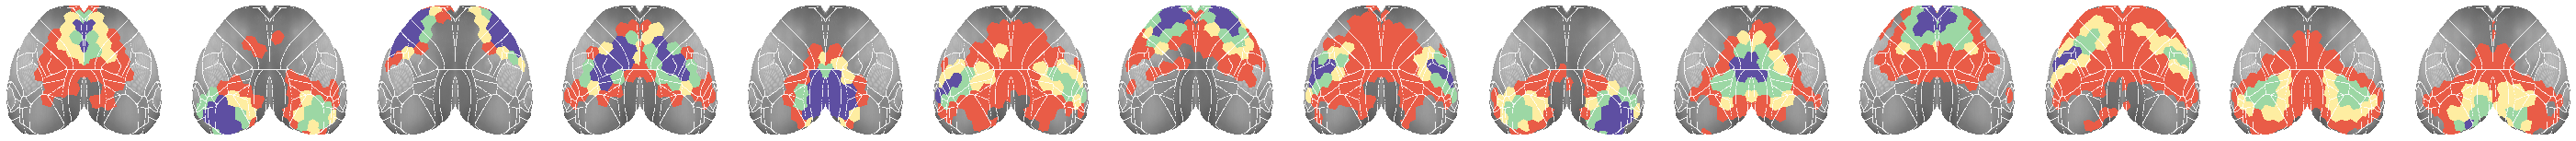

In [47]:
_ = self.show(
    data=members.astype(float),
    vmin=0.1,
    vmax=1.0,
    cmap='Spectral',
    coarse=False,
    width=0.001,
    add_disjoint=False,
    figsize=(50, 8),
)

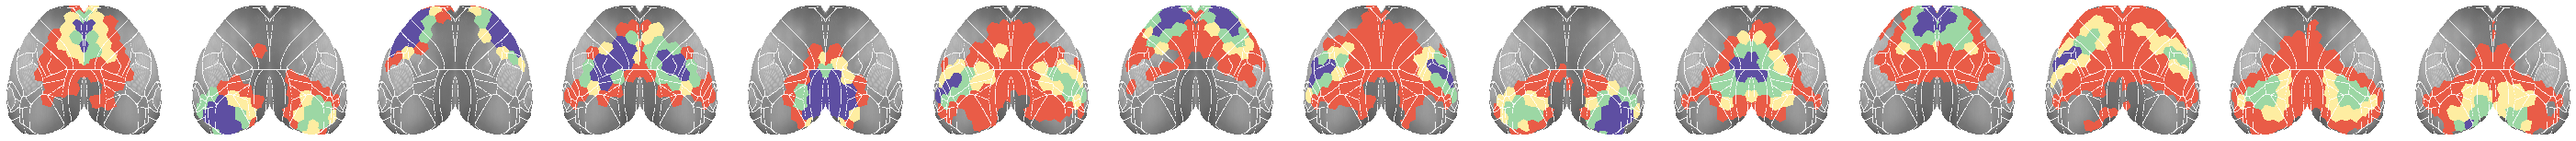